# ECGR 5105 Final Project: FAA Flight Delay Dataset
**Owen Bailey-Waltz (801488178)**

[Link to dataset on Kaggle](https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024)

In [1]:
# import required packages, load data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from google.colab import drive
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# check for CUDA
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cuda


In [3]:
#!pip install kaggle

In [4]:
# data import code (from Kaggle)
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md
)

print("First 5 records:")
display(df.head())

/tmp/ipython-input-2032139145.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'flight-data-2024' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


First 5 records:


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [5]:
# pre-process data with PyTorch
# note: flight number is not included since carrier and scheduled departure
# time both already convey this information
# serialize dates
flight_inputs = df[['year', 'month', 'day_of_month','day_of_week', 'op_unique_carrier',
                    'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 'distance', 'dep_delay', 'crs_elapsed_time', 'taxi_out' ]]
#fl_date = np.zeros(len(flight_inputs))
#for i in range(len(flight_inputs)):
#  fl_day = datetime.date(df['year'][i], df['month'][i],
#                         df['day_of_month'][i]) - datetime.date(2023,12,31)
#  fl_date[i] = fl_day.days
#display(fl_date)

In [6]:
flight_inputs.pop('year')
#flight_inputs.pop('month')
#flight_inputs.pop('day_of_month')
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,9E,JFK,DTW,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,9E,MSP,CLE,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,9E,JFK,RIC,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,9E,RIC,JFK,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,9E,DTW,MKE,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,YX,MYR,LGA,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,YX,JFK,PWM,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,YX,PWM,JFK,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,YX,JFK,SYR,1530,1659,209.0,-6.0,89.0,30.0


In [7]:
#flight_inputs.insert(0, 'fl_date', fl_date)
flight_inputs

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,9E,JFK,DTW,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,9E,MSP,CLE,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,9E,JFK,RIC,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,9E,RIC,JFK,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,9E,DTW,MKE,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,YX,MYR,LGA,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,YX,JFK,PWM,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,YX,PWM,JFK,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,YX,JFK,SYR,1530,1659,209.0,-6.0,89.0,30.0


In [8]:
#serialize airline carrier codes and FAA airport codes
display(pd.Categorical(flight_inputs['op_unique_carrier']).codes)
display(pd.Categorical(flight_inputs['origin']).codes)
display(pd.Categorical(flight_inputs['dest']).codes)
display(pd.Categorical(flight_inputs['op_unique_carrier']).categories)
display(pd.Categorical(flight_inputs['origin']).categories)
display(pd.Categorical(flight_inputs['dest']).categories)
flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
flight_inputs['dest'] = pd.Categorical(flight_inputs['dest']).codes
flight_inputs

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int8)

array([173, 227, 173, ..., 268, 173, 324], dtype=int16)

array([ 98,  67, 275, ..., 173, 324, 173], dtype=int16)

Index(['9E', 'AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO',
       'UA', 'WN', 'YX'],
      dtype='object')

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK',
       ...
       'VCT', 'VEL', 'VLD', 'VPS', 'WRG', 'WYS', 'XNA', 'XWA', 'YAK', 'YUM'],
      dtype='object', length=348)

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK',
       ...
       'VCT', 'VEL', 'VLD', 'VPS', 'WRG', 'WYS', 'XNA', 'XWA', 'YAK', 'YUM'],
      dtype='object', length=348)

/tmp/ipython-input-2110285055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
/tmp/ipython-input-2110285055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
/tmp/ipython-input-2110285055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1,1,1,0,173,98,1252,1508,509.0,-5.0,136.0,31.0
1,1,1,1,0,227,67,1015,1325,622.0,-14.0,130.0,20.0
2,1,1,1,0,173,275,1415,1601,288.0,-4.0,106.0,21.0
3,1,1,1,0,275,173,1650,1841,288.0,-7.0,111.0,13.0
4,1,1,1,0,98,217,1015,1034,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12,31,2,14,231,193,1226,1423,563.0,-6.0,117.0,14.0
7079077,12,31,2,14,173,268,950,1119,273.0,-11.0,89.0,17.0
7079078,12,31,2,14,268,173,1200,1329,273.0,-7.0,89.0,25.0
7079079,12,31,2,14,173,324,1530,1659,209.0,-6.0,89.0,30.0


In [9]:
# look for null values and replace with mean
# chosen input features should not have any null values based on previous
# inspection of dataset
flight_inputs.isnull().sum() * 100 / flight_inputs.shape[0]

,0
month,0.000000
day_of_month,0.000000
day_of_week,0.000000
op_unique_carrier,0.000000
origin,0.000000
dest,0.000000
crs_dep_time,0.000000
crs_arr_time,0.000000
distance,0.000000
dep_delay,1.313306


In [10]:
# make sure everything is float32 for use in neural network applications
# fill null values in arr_delay before converting to tensor
flight_inputs['dep_delay'] = flight_inputs['dep_delay'].fillna(0)
flight_inputs['crs_elapsed_time'] = flight_inputs['crs_elapsed_time'].fillna(0)
flight_inputs['taxi_out'] = flight_inputs['taxi_out'].fillna(0)
flight_inputs = flight_inputs.astype(np.float32)
flight_inputs

/tmp/ipython-input-3027631277.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['dep_delay'] = flight_inputs['dep_delay'].fillna(0)
/tmp/ipython-input-3027631277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['crs_elapsed_time'] = flight_inputs['crs_elapsed_time'].fillna(0)
/tmp/ipython-input-3027631277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,distance,dep_delay,crs_elapsed_time,taxi_out
0,1.0,1.0,1.0,0.0,173.0,98.0,1252.0,1508.0,509.0,-5.0,136.0,31.0
1,1.0,1.0,1.0,0.0,227.0,67.0,1015.0,1325.0,622.0,-14.0,130.0,20.0
2,1.0,1.0,1.0,0.0,173.0,275.0,1415.0,1601.0,288.0,-4.0,106.0,21.0
3,1.0,1.0,1.0,0.0,275.0,173.0,1650.0,1841.0,288.0,-7.0,111.0,13.0
4,1.0,1.0,1.0,0.0,98.0,217.0,1015.0,1034.0,237.0,-5.0,79.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,12.0,31.0,2.0,14.0,231.0,193.0,1226.0,1423.0,563.0,-6.0,117.0,14.0
7079077,12.0,31.0,2.0,14.0,173.0,268.0,950.0,1119.0,273.0,-11.0,89.0,17.0
7079078,12.0,31.0,2.0,14.0,268.0,173.0,1200.0,1329.0,273.0,-7.0,89.0,25.0
7079079,12.0,31.0,2.0,14.0,173.0,324.0,1530.0,1659.0,209.0,-6.0,89.0,30.0


In [11]:
# replace null delays with zero
delay_label_cols = ['security_delay','arr_delay', 'cancelled']
df[delay_label_cols] = df[delay_label_cols].fillna(0)
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [12]:
# bring in our output features
cancelled = df['cancelled']
dep_delay = df['arr_delay']
security_delay = df['security_delay']


## Data setup and initial experiments

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Inputs (features)
X = flight_inputs   # all columns you listed

# Outputs (multiple ground truths)
y_cancelled = df["cancelled"]        # classification target
y_arr_delay = df["arr_delay"]        # regression target
y_security = df["security_delay"]    # regression target

# -----------------------------
# 1. Train/Test Split (80:20)
# -----------------------------
X_train, X_test, y_cancelled_train, y_cancelled_test, y_arr_train, y_arr_test, y_sec_train, y_sec_test = train_test_split(
    X, y_cancelled, y_arr_delay, y_security,
    test_size=0.2,
    random_state=42   # reproducibility
)

# -----------------------------
# 2. Standardize Inputs
# -----------------------------
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Now you have:
# -----------------------------
# X_train_scaled, X_test_scaled → standardized inputs
# y_cancelled_train/test → ground truth for cancelled
# y_arr_train/test → ground truth for arrival delay
# y_sec_train/test → ground truth for security delay


In [ ]:
#WholeYear = pd.concat([flight_inputs,cancelled,dep_delay,security_delay],axis=1)
#print(WholeYear.head())

Here we make copies of splits: sets for cancellation, arrival delay, security delay

In [ ]:
'''
# split training and validation sets
X = torch.tensor(flight_inputs.to_numpy(), dtype=torch.float32)
cancelled = torch.tensor(cancelled, dtype=torch.long)
dep_delay = torch.tensor(dep_delay, dtype=torch.float32)
security_delay = torch.tensor(security_delay, dtype=torch.float32)
#late_aircraft_delay = torch.tensor(late_aircraft_delay, dtype=torch.float32)
n = X.shape[0]
n_val = int(0.2 * n)

shuffled_indices = torch.randperm(n)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

X_train = X[train_indices]
X_val = X[val_indices]

dep_delay_train = dep_delay[train_indices]
dep_delay_val = dep_delay[val_indices]
cancelled_train = cancelled[train_indices]
cancelled_val = cancelled[val_indices]
security_delay_train = security_delay[train_indices]
security_delay_val = security_delay[val_indices]
'''

'\n# split training and validation sets\nX = torch.tensor(flight_inputs.to_numpy(), dtype=torch.float32)\ncancelled = torch.tensor(cancelled, dtype=torch.long)\ndep_delay = torch.tensor(dep_delay, dtype=torch.float32)\nsecurity_delay = torch.tensor(security_delay, dtype=torch.float32)\n#late_aircraft_delay = torch.tensor(late_aircraft_delay, dtype=torch.float32)\nn = X.shape[0]\nn_val = int(0.2 * n)\n\nshuffled_indices = torch.randperm(n)\ntrain_indices = shuffled_indices[:-n_val]\nval_indices = shuffled_indices[-n_val:]\n\nX_train = X[train_indices]\nX_val = X[val_indices]\n\ndep_delay_train = dep_delay[train_indices]\ndep_delay_val = dep_delay[val_indices]\ncancelled_train = cancelled[train_indices]\ncancelled_val = cancelled[val_indices]\nsecurity_delay_train = security_delay[train_indices]\nsecurity_delay_val = security_delay[val_indices]\n'

In [ ]:
'''
df['arr_delay'].isnull().sum()
'''

"\ndf['arr_delay'].isnull().sum()\n"

In [ ]:
'''
# standardize input features
for col in range(X_train.shape[1]):
  mu = torch.mean(X_train[:, col])
  sigma = torch.std(X_train[:, col])
  X_train[:, col] = (X_train[:, col] - mu) / sigma
  X_val[:, col] = (X_val[:, col] - mu) / sigma

X_train
'''

'\n# standardize input features\nfor col in range(X_train.shape[1]):\n  mu = torch.mean(X_train[:, col])\n  sigma = torch.std(X_train[:, col])\n  X_train[:, col] = (X_train[:, col] - mu) / sigma\n  X_val[:, col] = (X_val[:, col] - mu) / sigma\n\nX_train\n'

Arrival Delay models

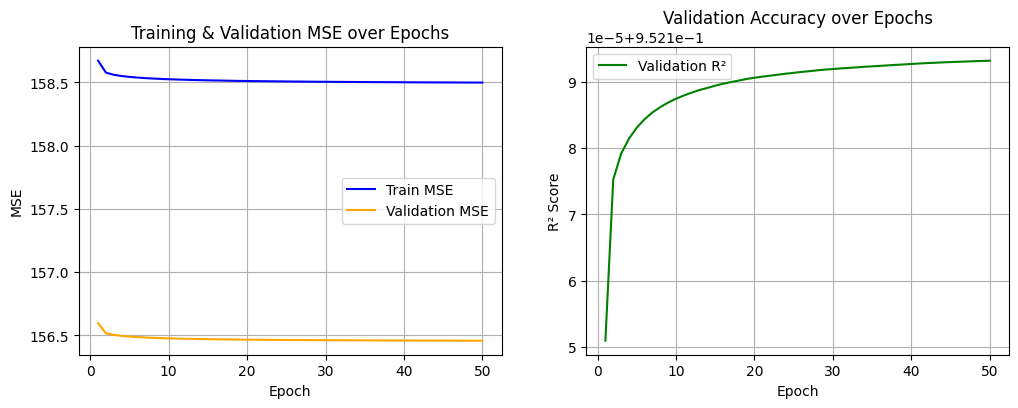

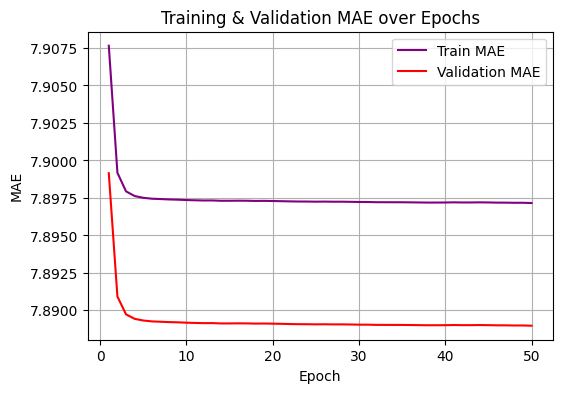

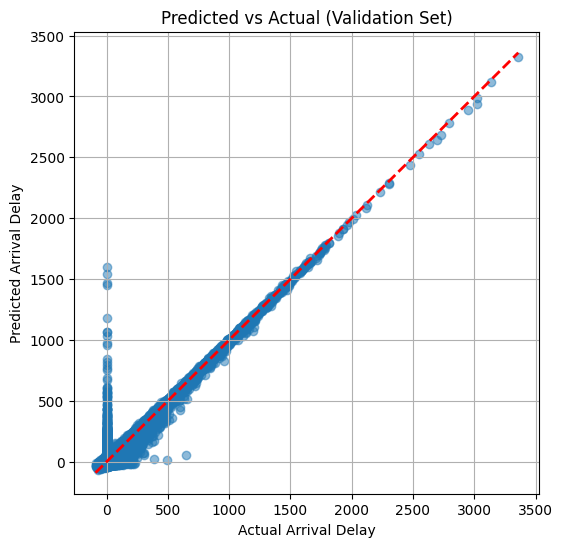

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. SGDRegressor to simulate epochs
# -----------------------------
n_epochs = 50
train_mse_list = []
val_mse_list = []
train_mae_list = []
val_mae_list = []
val_r2_scores = []

sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='invscaling',
    eta0=0.001,
    random_state=42,
    penalty="l2",
    alpha=0.0001
)

for epoch in range(n_epochs):
    # partial_fit trains one epoch at a time
    sgd.partial_fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_arr_train)

    # Predictions
    y_train_pred = sgd.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
    y_val_pred = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

    # Losses
    train_mse = mean_squared_error(y_arr_train, y_train_pred)
    val_mse = mean_squared_error(y_arr_test, y_val_pred)
    train_mae = mean_absolute_error(y_arr_train, y_train_pred)
    val_mae = mean_absolute_error(y_arr_test, y_val_pred)
    val_r2 = r2_score(y_arr_test, y_val_pred)

    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    val_r2_scores.append(val_r2)

# -----------------------------
# 2. Plot Training & Validation MSE
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_mse_list, label="Train MSE", color="blue")
plt.plot(range(1, n_epochs+1), val_mse_list, label="Validation MSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation MSE over Epochs")
plt.legend()
plt.grid(True)

# -----------------------------
# 3. Plot Validation Accuracy (R²)
# -----------------------------
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), val_r2_scores, label="Validation R²", color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4. Plot Training & Validation MAE
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), train_mae_list, label="Train MAE", color="purple")
plt.plot(range(1, n_epochs+1), val_mae_list, label="Validation MAE", color="red")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Predicted vs Actual Scatter Plot
# -----------------------------
y_val_pred_final = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

plt.figure(figsize=(6,6))
plt.scatter(y_arr_test, y_val_pred_final, alpha=0.5)
plt.plot([y_arr_test.min(), y_arr_test.max()],
         [y_arr_test.min(), y_arr_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

class TrainingPlotter:
    def __init__(self, metrics, y_true=None, y_pred=None):
        """
        metrics: dict containing lists of metrics per epoch
                 keys: 'train_mse', 'val_mse', 'train_mae', 'val_mae', 'val_r2'
        y_true: ground truth values (for scatter plot)
        y_pred: predicted values (for scatter plot)
        """
        self.metrics = metrics
        self.y_true = y_true
        self.y_pred = y_pred

    def plot_losses(self):
        """Plot Training & Validation MSE"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["train_mse"], label="Train MSE", color="blue")
        plt.plot(self.metrics["val_mse"], label="Val MSE", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.title("Training & Validation MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_mae(self):
        """Plot Training & Validation MAE"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["train_mae"], label="Train MAE", color="purple")
        plt.plot(self.metrics["val_mae"], label="Val MAE", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.title("Training & Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_r2(self):
        """Plot Validation R²"""
        plt.figure(figsize=(6,4))
        plt.plot(self.metrics["val_r2"], label="Val R²", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("R² Score")
        plt.title("Validation Accuracy (R²)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_pred_vs_actual(self):
        """Scatter plot of predicted vs actual values"""
        if self.y_true is None or self.y_pred is None:
            raise ValueError("y_true and y_pred must be provided for scatter plot.")
        plt.figure(figsize=(6,6))
        plt.scatter(self.y_true, self.y_pred, alpha=0.5)
        plt.plot([self.y_true.min(), self.y_true.max()],
                 [self.y_true.min(), self.y_true.max()],
                 'r--', lw=2)  # perfect prediction line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs Actual (Validation Set)")
        plt.grid(True)
        plt.show()


SVR Regression Linear for practicality of training time for millions of datapoints

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. Define SVR model
# -----------------------------
# RBF kernel is common for capturing nonlinear relationships
svr = LinearSVR(C=1.0, epsilon=1.0, max_iter=10000)


# -----------------------------
# 2. Train
# -----------------------------
svr.fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_arr_train)

# -----------------------------
# 3. Predict
# -----------------------------
y_train_pred = svr.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
y_test_pred  = svr.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

# -----------------------------
# 4. Metrics
# -----------------------------
train_mse = mean_squared_error(y_arr_train, y_train_pred)
train_mae = mean_absolute_error(y_arr_train, y_train_pred)

test_mse = mean_squared_error(y_arr_test, y_test_pred)
test_mae = mean_absolute_error(y_arr_test, y_test_pred)
test_r2  = r2_score(y_arr_test, y_test_pred)

print(f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f}")
print(f"Test MSE={test_mse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.4f}")


Train MSE=160.492, MAE=7.809
Test MSE=158.524, MAE=7.803, R²=0.9516


In [82]:
#NN Model
# Here I am choosing a FCNN for the following reason: each flight is independent, therefore it doesnt need to depend on previous pasts states, Time is encoded as features, not sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

#pytorch can embed catagorical values so we seperate
# -----------------------------
# 1. Split into train/test
# -----------------------------
X_train, X_test, y_cancelled_train, y_cancelled_test, y_arr_train, y_arr_test, y_sec_train, y_sec_test = train_test_split(
    flight_inputs,
    df["cancelled"],
    df["arr_delay"],
    df["security_delay"],
    test_size=0.2,
    random_state=42
)

# -----------------------------
# 2. Separate numeric vs categorical
# -----------------------------
numeric_cols = ["month","day_of_month","day_of_week",
                "crs_dep_time","crs_arr_time","distance",
                "dep_delay","crs_elapsed_time","taxi_out"]

cat_cols = ["op_unique_carrier","origin","dest"]

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

# Keep categorical features as integer codes
X_train_carrier = X_train["op_unique_carrier"].astype(int).values
X_train_origin  = X_train["origin"].astype(int).values
X_train_dest    = X_train["dest"].astype(int).values

X_test_carrier = X_test["op_unique_carrier"].astype(int).values
X_test_origin  = X_test["origin"].astype(int).values
X_test_dest    = X_test["dest"].astype(int).values




In [83]:
# Unique category counts
num_carriers = df["op_unique_carrier"].nunique()
num_airports = pd.concat([df["origin"], df["dest"]]).nunique()

# Numeric features (scaled)
X_train_num_t = torch.tensor(X_train_num, dtype=torch.float32)
X_test_num_t  = torch.tensor(X_test_num, dtype=torch.float32)

# Categorical features (IDs)
X_train_carrier_t = torch.tensor(X_train_carrier, dtype=torch.long)
X_train_origin_t  = torch.tensor(X_train_origin, dtype=torch.long)
X_train_dest_t    = torch.tensor(X_train_dest, dtype=torch.long)

X_test_carrier_t = torch.tensor(X_test_carrier, dtype=torch.long)
X_test_origin_t  = torch.tensor(X_test_origin, dtype=torch.long)
X_test_dest_t    = torch.tensor(X_test_dest, dtype=torch.long)

# Targets
y_arr_train_t = torch.tensor(y_arr_train.values, dtype=torch.float32).unsqueeze(1)
y_arr_test_t  = torch.tensor(y_arr_test.values, dtype=torch.float32).unsqueeze(1)


In [84]:
from torch.utils.data import Dataset, DataLoader

class FlightDataset(Dataset):
    def __init__(self, X_num, X_carrier, X_origin, X_dest, y_arr):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_carrier = torch.tensor(X_carrier, dtype=torch.long)
        self.X_origin = torch.tensor(X_origin, dtype=torch.long)
        self.X_dest = torch.tensor(X_dest, dtype=torch.long)
        self.y_arr = torch.tensor(y_arr.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        return (self.X_num[idx],
                self.X_carrier[idx],
                self.X_origin[idx],
                self.X_dest[idx],
                self.y_arr[idx])


In [85]:
batch_size = 256

train_dataset = FlightDataset(X_train_num, X_train_carrier, X_train_origin, X_train_dest, y_arr_train)
test_dataset  = FlightDataset(X_test_num, X_test_carrier, X_test_origin, X_test_dest, y_arr_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [78]:
import torch
import torch.nn as nn


class FlightDelayFCNN(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)


### Neural network training loop
This section marks the beginning of neural network training. The interpreter located at the bottom of this notebook requires all cells not including training loops up to this point to be executed.

In [ ]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Now training on device {device}')

# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 5
metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")


Now training on device cuda
Epoch 01 | Train MSE=173.969, MAE=7.950 | Val MSE=135.827, MAE=7.125, R²=0.9585
Epoch 02 | Train MSE=144.650, MAE=7.251 | Val MSE=154.817, MAE=7.631, R²=0.9527
Epoch 03 | Train MSE=139.474, MAE=7.067 | Val MSE=125.697, MAE=6.928, R²=0.9616
Epoch 04 | Train MSE=135.181, MAE=6.960 | Val MSE=123.019, MAE=6.878, R²=0.9624
Epoch 05 | Train MSE=132.851, MAE=6.897 | Val MSE=121.092, MAE=6.798, R²=0.9630

Total training time for 5 epochs: 913.94 seconds


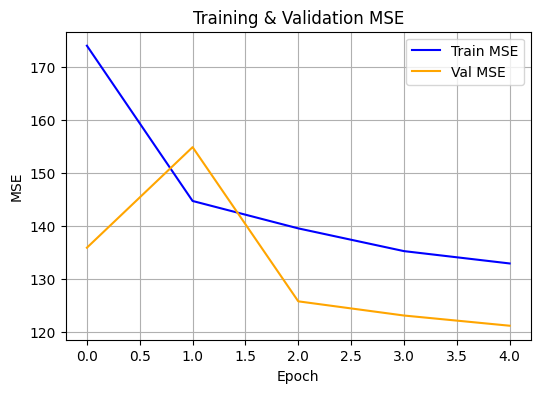

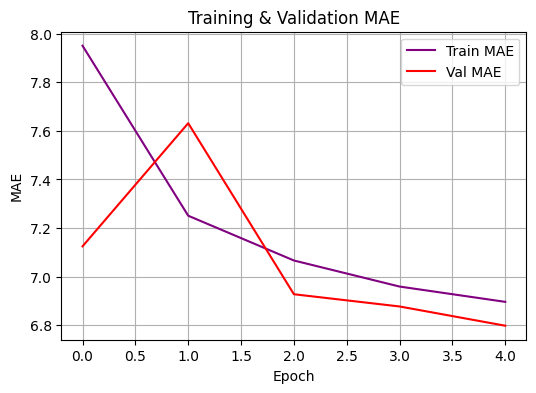

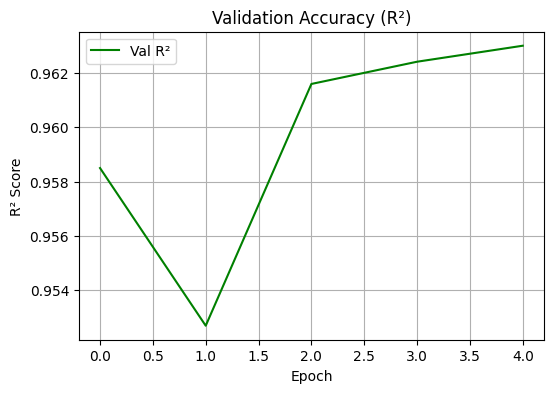

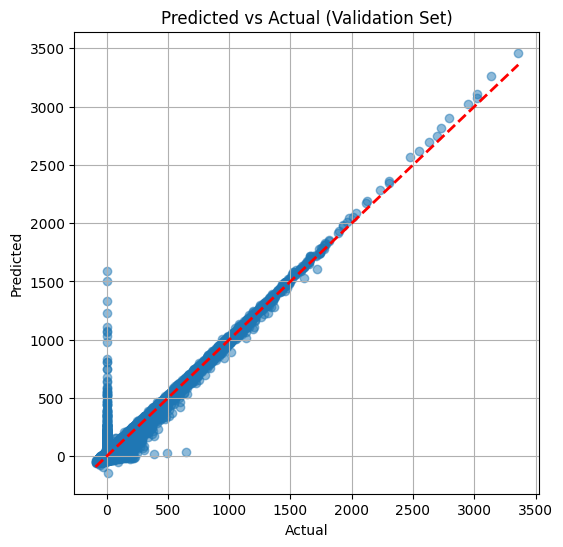

In [ ]:
plotter = TrainingPlotter(metrics,
                          y_true=y_arr_test_t.numpy(),
                          y_pred=val_preds)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()


In [ ]:
file_path = '/content/drive/MyDrive/models/arr_delay.bin'
torch.save(model.state_dict(), file_path)

## $p=0.3$, reduced epochs

In [ ]:
class FlightDelayFCNN2(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)

In [ ]:
# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN2(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 15
metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")

In [ ]:
plotter = TrainingPlotter(metrics,
                          y_true=y_arr_test_t.numpy(),
                          y_pred=val_preds)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()

## $p=0.1$, reduced epochs

In [ ]:
import time
# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 15
metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")
plotter = TrainingPlotter(metrics,
                          y_true=y_arr_test_t.numpy(),
                          y_pred=val_preds)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()

In [ ]:
file_path = '/content/drive/MyDrive/models/arr_delay.bin'
torch.save(model.state_dict(), file_path)

## Carrier delay

### Linear regression

In [ ]:
X_train, X_test, y_diverted_train, y_diverted_test, y_carrier_train, y_carrier_test, y_late_aircraft_train, y_late_aircraft_test = train_test_split(
    flight_inputs,
    df["diverted"],
    df["carrier_delay"],
    df["late_aircraft_delay"],
    test_size=0.2,
    random_state=42
)

In [ ]:
# -----------------------------
# 2. Standardize Inputs
# -----------------------------
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Now you have:
# -----------------------------
# X_train_scaled, X_test_scaled → standardized inputs
# y_cancelled_train/test → ground truth for cancelled
# y_arr_train/test → ground truth for arrival delay
# y_sec_train/test → ground truth for security delay

In [ ]:
# -----------------------------
# 1. SGDRegressor to simulate epochs
# -----------------------------
n_epochs = 500
train_mse_list = []
val_mse_list = []
train_mae_list = []
val_mae_list = []
val_r2_scores = []

sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='invscaling',
    eta0=0.0000001,
    random_state=42,
    penalty="l2",
    alpha=0.0001
)

for epoch in range(n_epochs):
    # partial_fit trains one epoch at a time
    sgd.partial_fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_carrier_train)

    # Predictions
    y_train_pred = sgd.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
    y_val_pred = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

    # Losses
    train_mse = mean_squared_error(y_carrier_train, y_train_pred)
    val_mse = mean_squared_error(y_carrier_test, y_val_pred)
    train_mae = mean_absolute_error(y_carrier_train, y_train_pred)
    val_mae = mean_absolute_error(y_carrier_test, y_val_pred)
    val_r2 = r2_score(y_carrier_test, y_val_pred)

    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    val_r2_scores.append(val_r2)

# -----------------------------
# 2. Plot Training & Validation MSE
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_mse_list, label="Train MSE", color="blue")
plt.plot(range(1, n_epochs+1), val_mse_list, label="Validation MSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation MSE over Epochs")
plt.legend()
plt.grid(True)

# -----------------------------
# 3. Plot Validation Accuracy (R²)
# -----------------------------
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), val_r2_scores, label="Validation R²", color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4. Plot Training & Validation MAE
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), train_mae_list, label="Train MAE", color="purple")
plt.plot(range(1, n_epochs+1), val_mae_list, label="Validation MAE", color="red")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Predicted vs Actual Scatter Plot
# -----------------------------
y_val_pred_final = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

plt.figure(figsize=(6,6))
plt.scatter(y_carrier_test, y_val_pred_final, alpha=0.5)
plt.plot([y_carrier_test.min(), y_carrier_test.max()],
         [y_carrier_test.min(), y_carrier_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.show()

### Support vector regression

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. Define SVR model
# -----------------------------
# RBF kernel is common for capturing nonlinear relationships
svr = LinearSVR(C=1.0, epsilon=1.0, max_iter=10000)


# -----------------------------
# 2. Train
# -----------------------------
svr.fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_carrier_train)

# -----------------------------
# 3. Predict
# -----------------------------
y_train_pred = svr.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
y_test_pred  = svr.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

# -----------------------------
# 4. Metrics
# -----------------------------
train_mse = mean_squared_error(y_carrier_train, y_train_pred)
train_mae = mean_absolute_error(y_carrier_train, y_train_pred)

test_mse = mean_squared_error(y_carrier_test, y_test_pred)
test_mae = mean_absolute_error(y_carrier_test, y_test_pred)
test_r2  = r2_score(y_carrier_test, y_test_pred)

print(f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f}")
print(f"Test MSE={test_mse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.4f}")

### Neural network

In [ ]:
# -----------------------------
# 2. Separate numeric vs categorical
# -----------------------------
numeric_cols = ["month","day_of_month","day_of_week",
                "crs_dep_time","crs_arr_time","distance",
                "dep_delay","crs_elapsed_time","taxi_out"]

cat_cols = ["op_unique_carrier","origin","dest"]

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

# Keep categorical features as integer codes
X_train_carrier = X_train["op_unique_carrier"].astype(int).values
X_train_origin  = X_train["origin"].astype(int).values
X_train_dest    = X_train["dest"].astype(int).values

X_test_carrier = X_test["op_unique_carrier"].astype(int).values
X_test_origin  = X_test["origin"].astype(int).values
X_test_dest    = X_test["dest"].astype(int).values

In [ ]:
batch_size = 256

train_dataset = FlightDataset(X_train_num, X_train_carrier, X_train_origin, X_train_dest, y_carrier_train)
test_dataset  = FlightDataset(X_test_num, X_test_carrier, X_test_origin, X_test_dest, y_carrier_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 01 | Train MSE=592.766, MAE=5.573 | Val MSE=534.102, MAE=5.082, R²=0.5775
Epoch 02 | Train MSE=558.906, MAE=5.356 | Val MSE=528.456, MAE=5.089, R²=0.5820
Epoch 03 | Train MSE=541.930, MAE=5.281 | Val MSE=527.058, MAE=5.267, R²=0.5831
Epoch 04 | Train MSE=528.450, MAE=5.202 | Val MSE=516.878, MAE=5.318, R²=0.5911
Epoch 05 | Train MSE=513.727, MAE=5.150 | Val MSE=524.608, MAE=5.307, R²=0.5850

Total training time for 5 epochs: 925.27 seconds


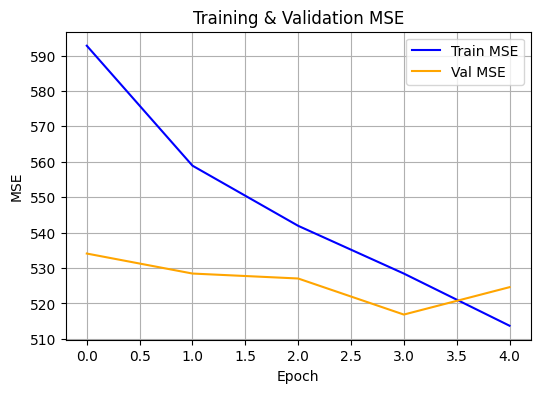

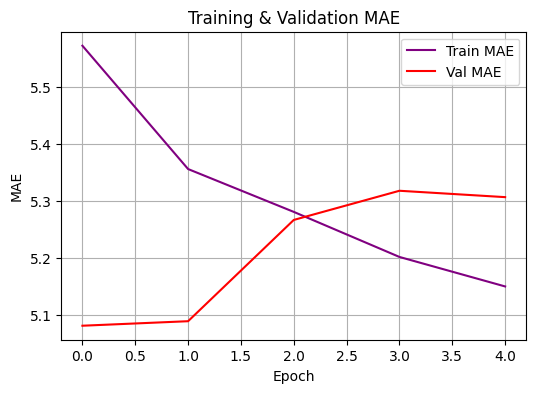

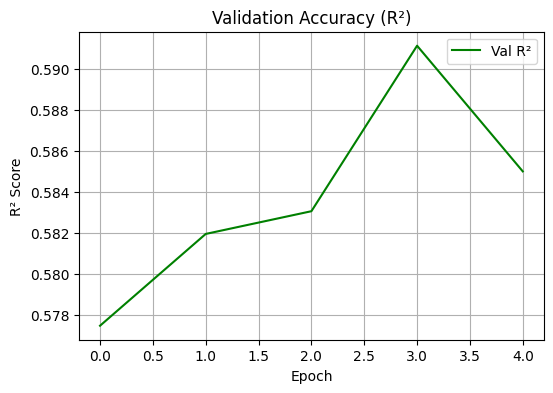

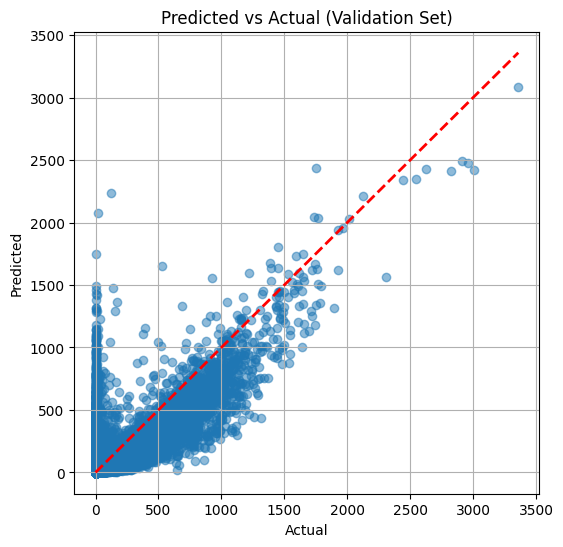

In [ ]:
# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 5
metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")
plotter = TrainingPlotter(metrics,
                          y_true=y_carrier_test,
                          y_pred=val_preds)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()

In [ ]:
file_path = '/content/drive/MyDrive/models/carrier_delay_fcnn.bin'
torch.save(model.state_dict(), file_path)

## Late aircraft delay

### Linear regression

In [ ]:
# -----------------------------
# 1. SGDRegressor to simulate epochs
# -----------------------------
n_epochs = 500
train_mse_list = []
val_mse_list = []
train_mae_list = []
val_mae_list = []
val_r2_scores = []

sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='invscaling',
    eta0=0.0000001,
    random_state=42,
    penalty="l2",
    alpha=0.0001
)

for epoch in range(n_epochs):
    # partial_fit trains one epoch at a time
    sgd.partial_fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_late_aircraft_train)

    # Predictions
    y_train_pred = sgd.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
    y_val_pred = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

    # Losses
    train_mse = mean_squared_error(y_late_aircraft_train, y_train_pred)
    val_mse = mean_squared_error(y_late_aircraft_test, y_val_pred)
    train_mae = mean_absolute_error(y_late_aircraft_train, y_train_pred)
    val_mae = mean_absolute_error(y_late_aircraft_test, y_val_pred)
    val_r2 = r2_score(y_late_aircraft_test, y_val_pred)

    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    val_r2_scores.append(val_r2)

# -----------------------------
# 2. Plot Training & Validation MSE
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_mse_list, label="Train MSE", color="blue")
plt.plot(range(1, n_epochs+1), val_mse_list, label="Validation MSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation MSE over Epochs")
plt.legend()
plt.grid(True)

# -----------------------------
# 3. Plot Validation Accuracy (R²)
# -----------------------------
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), val_r2_scores, label="Validation R²", color="green")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4. Plot Training & Validation MAE
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), train_mae_list, label="Train MAE", color="purple")
plt.plot(range(1, n_epochs+1), val_mae_list, label="Validation MAE", color="red")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Predicted vs Actual Scatter Plot
# -----------------------------
y_val_pred_final = sgd.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

plt.figure(figsize=(6,6))
plt.scatter(y_late_aircraft_test, y_val_pred_final, alpha=0.5)
plt.plot([y_late_aircraft_test.min(), y_late_aircraft_test.max()],
         [y_late_aircraft_test.min(), y_late_aircraft_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.show()

### Support vector regression

In [ ]:
# -----------------------------
# 1. Define SVR model
# -----------------------------
# RBF kernel is common for capturing nonlinear relationships
svr = LinearSVR(C=1.0, epsilon=1.0, max_iter=10000)


# -----------------------------
# 2. Train
# -----------------------------
svr.fit(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]], y_late_aircraft_train)

# -----------------------------
# 3. Predict
# -----------------------------
y_train_pred = svr.predict(X_train_scaled[:, [0,1,2,6,7,8,9,10,11]])
y_test_pred  = svr.predict(X_test_scaled[:, [0,1,2,6,7,8,9,10,11]])

# -----------------------------
# 4. Metrics
# -----------------------------
train_mse = mean_squared_error(y_late_aircraft_train, y_train_pred)
train_mae = mean_absolute_error(y_late_aircraft_train, y_train_pred)

test_mse = mean_squared_error(y_late_aircraft_test, y_test_pred)
test_mae = mean_absolute_error(y_late_aircraft_test, y_test_pred)
test_r2  = r2_score(y_late_aircraft_test, y_test_pred)

print(f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f}")
print(f"Test MSE={test_mse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.4f}")

### Neural network

In [ ]:
batch_size = 256

train_dataset = FlightDataset(X_train_num, X_train_carrier, X_train_origin, X_train_dest, y_late_aircraft_train)
test_dataset  = FlightDataset(X_test_num, X_test_carrier, X_test_origin, X_test_dest, y_late_aircraft_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 01 | Train MSE=497.499, MAE=5.250 | Val MSE=433.905, MAE=4.704, R²=0.5254
Epoch 02 | Train MSE=468.490, MAE=5.040 | Val MSE=425.338, MAE=4.889, R²=0.5347
Epoch 03 | Train MSE=454.493, MAE=4.926 | Val MSE=419.663, MAE=4.954, R²=0.5409
Epoch 04 | Train MSE=440.433, MAE=4.912 | Val MSE=427.033, MAE=5.183, R²=0.5329
Epoch 05 | Train MSE=430.720, MAE=4.874 | Val MSE=419.460, MAE=5.018, R²=0.5412
Epoch 06 | Train MSE=421.011, MAE=4.840 | Val MSE=427.923, MAE=5.191, R²=0.5319
Epoch 07 | Train MSE=413.345, MAE=4.824 | Val MSE=422.860, MAE=5.191, R²=0.5374
Epoch 08 | Train MSE=403.920, MAE=4.797 | Val MSE=423.838, MAE=5.279, R²=0.5364
Epoch 09 | Train MSE=396.756, MAE=4.764 | Val MSE=424.644, MAE=5.082, R²=0.5355
Epoch 10 | Train MSE=391.419, MAE=4.762 | Val MSE=431.447, MAE=5.263, R²=0.5281

Total training time for 10 epochs: 1831.52 seconds


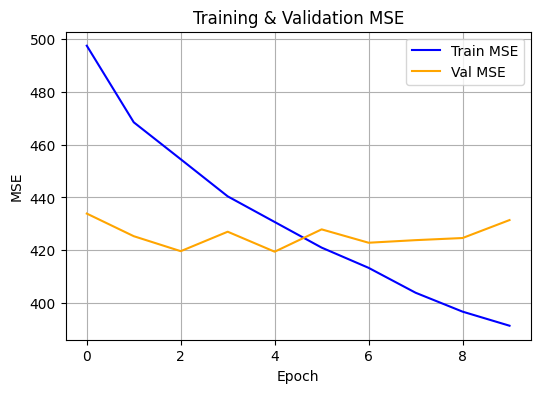

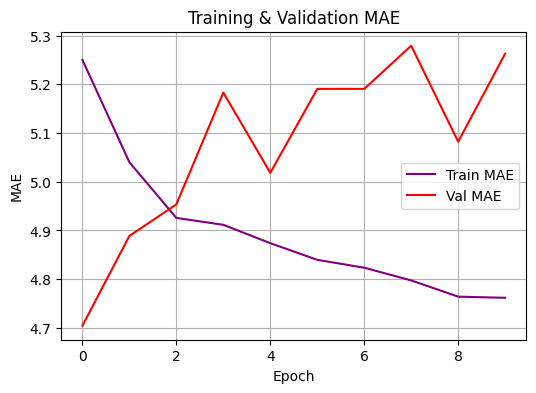

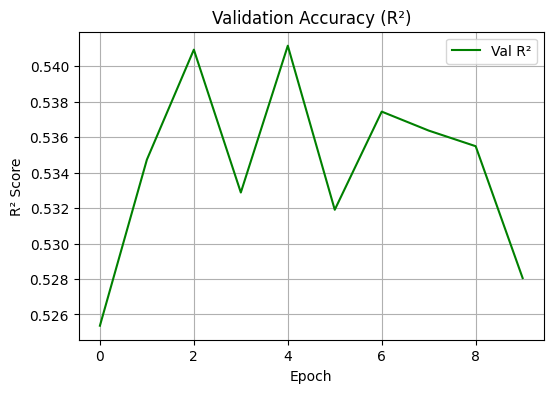

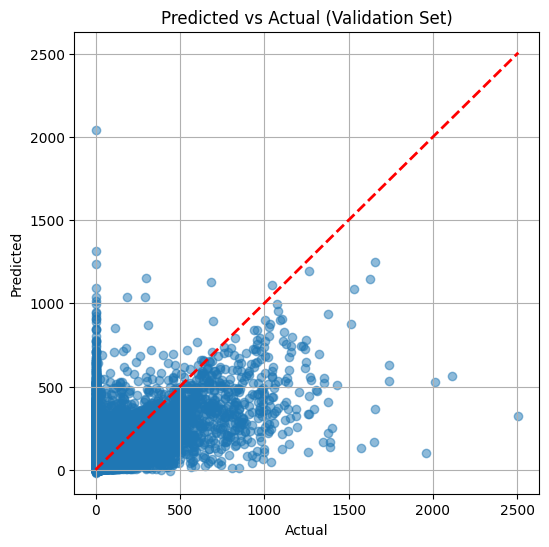

In [ ]:
# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNN(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 10
metrics = {"train_mse": [], "val_mse": [], "train_mae": [], "val_mae": [], "val_r2": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_mse = mean_squared_error(train_targets, train_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_mse = mean_squared_error(val_targets, val_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    # Store metrics
    metrics["train_mse"].append(train_mse)
    metrics["val_mse"].append(val_mse)
    metrics["train_mae"].append(train_mae)
    metrics["val_mae"].append(val_mae)
    metrics["val_r2"].append(val_r2)

    print(f"Epoch {epoch+1:02d} | "
          f"Train MSE={train_mse:.3f}, MAE={train_mae:.3f} | "
          f"Val MSE={val_mse:.3f}, MAE={val_mae:.3f}, R²={val_r2:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")
plotter = TrainingPlotter(metrics,
                          y_true=y_late_aircraft_test,
                          y_pred=val_preds)

plotter.plot_losses()
plotter.plot_mae()
plotter.plot_r2()
plotter.plot_pred_vs_actual()

In [ ]:
file_path = '/content/drive/MyDrive/models/late_aircraft_delay.bin'
torch.save(model.state_dict(), file_path)

## Diversion classifier redux


### Logistic regression

In [ ]:
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train, y_diverted_train)

In [ ]:
y_pred = model.predict(X_test)
confusion = metrics.confusion_matrix(y_diverted_test, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train, y_diverted_train),
                    'Validation Accuracy': model.score(X_test, y_diverted_test),
                    'Precision': metrics.precision_score(y_diverted_test, y_pred),
                    'Recall': metrics.recall_score(y_diverted_test, y_pred),
                    'F1 Score': metrics.f1_score(y_diverted_test, y_pred)}

print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
coefficients = model.coef_[0]
for i in range(len(coefficients)):
  if coefficients[i] > 0:
    print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  elif coefficients[i] < 0:
    print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code frome example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

### Support vector classification

In [ ]:
model = SVC(kernel='rbf', class_weight='balanced', C=1, max_iter=100)
model.fit(X_train, y_diverted_train)

In [ ]:
y_pred = model.predict(X_test)
confusion = metrics.confusion_matrix(y_diverted_test, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train, y_diverted_train),
                    'Validation Accuracy': model.score(X_test, y_diverted_test),
                    'Precision': metrics.precision_score(y_diverted_test, y_pred),
                    'Recall': metrics.recall_score(y_diverted_test, y_pred),
                    'F1 Score': metrics.f1_score(y_diverted_test, y_pred)}

print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
coefficients = model.coef_[0]
for i in range(len(coefficients)):
  if coefficients[i] > 0:
    print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  elif coefficients[i] < 0:
    print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code frome example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

### Neural network classifier

In [ ]:
class FlightDelayFCNNClassifier(nn.Module):
    def __init__(self, num_numeric, n_carriers, n_airports,
                 emb_carrier=16, emb_airport=64):
        super().__init__()
        # Embeddings for categorical features
        self.emb_carrier = nn.Embedding(n_carriers, emb_carrier)
        self.emb_origin  = nn.Embedding(n_airports, emb_airport)
        self.emb_dest    = nn.Embedding(n_airports, emb_airport)

        # Total input dimension = numeric + embeddings
        in_dim = num_numeric + emb_carrier + 2*emb_airport

        # FCNN hidden layers
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)   # regression output: arr_delay
        )

    def forward(self, x_num, x_carrier, x_origin, x_dest):
        # Look up embeddings
        e_car = self.emb_carrier(x_carrier)
        e_org = self.emb_origin(x_origin)
        e_dst = self.emb_dest(x_dest)

        # Concatenate numeric + embeddings
        x = torch.cat([x_num, e_car, e_org, e_dst], dim=1)

        # Pass through FCNN
        return self.fc(x)

In [ ]:
batch_size = 256

train_dataset = FlightDataset(X_train_num, X_train_carrier, X_train_origin, X_train_dest, y_diverted_train)
test_dataset  = FlightDataset(X_test_num, X_test_carrier, X_test_origin, X_test_dest, y_diverted_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
# -----------------------------
# Training Setup
# -----------------------------
model = FlightDelayFCNNClassifier(num_numeric=9,
                        n_carriers=num_carriers,
                        n_airports=num_airports).to(device)   # move model to device

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -----------------------------
# Training Loop (metrics only)
# -----------------------------
n_epochs = 10
metrics = {"train_acc": [], "val_acc": [], "precision": [], "recall": [], "f1": []}

start_time = time.time()   # start timer

for epoch in range(n_epochs):
    # Training
    model.train()
    train_preds, train_targets = [], []
    for x_num, x_car, x_org, x_dst, y in train_loader:
        # move batch tensors to device
        x_num, x_car, x_org, x_dst, y = (
            x_num.to(device),
            x_car.to(device),
            x_org.to(device),
            x_dst.to(device),
            y.to(device)
        )

        optimizer.zero_grad()
        y_pred = model(x_num, x_car, x_org, x_dst)
        loss = criterion(y_pred, y.flatten().long())
        loss.backward()
        optimizer.step()

        train_preds.append(y_pred.detach().cpu())   # keep on CPU for metrics
        train_targets.append(y.detach().cpu())

    # Compute train metrics
    _, labels_preds = torch.max(torch.cat(train_preds), dim=1)
    train_preds = labels_preds.numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_acc = accuracy_score(train_targets, train_preds)

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for x_num, x_car, x_org, x_dst, y in test_loader:
            x_num, x_car, x_org, x_dst, y = (
                x_num.to(device),
                x_car.to(device),
                x_org.to(device),
                x_dst.to(device),
                y.to(device)
            )
            y_pred = model(x_num, x_car, x_org, x_dst)
            val_preds.append(y_pred.cpu())   # move back to CPU for metrics
            val_targets.append(y.cpu())

    _, labels_preds = torch.max(torch.cat(val_preds), dim=1)
    val_preds = labels_preds.numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_acc = accuracy_score(val_targets, val_preds)
    precision = precision_score(val_targets, val_preds)
    recall = recall_score(val_targets, val_preds)
    f1 = f1_score(val_targets, val_preds)

    # Store metrics
    metrics["train_acc"].append(train_acc)
    metrics["val_acc"].append(val_acc)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1"].append(f1)

    print(f"Epoch {epoch+1:02d} | "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f} | "
          f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

end_time = time.time()   # end timer
elapsed = end_time - start_time
print(f"\nTotal training time for {n_epochs} epochs: {elapsed:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 05 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 06 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 07 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 08 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 09 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 10 | Train Acc=0.9975, Val Acc=0.9976 | Precision=0.0000, Recall=0.0000, F1=0.0000

Total training time for 10 epochs: 1793.00 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


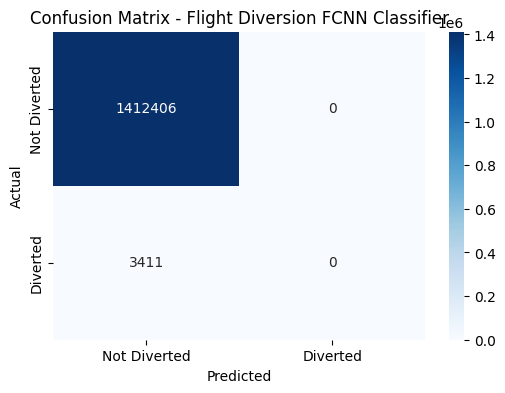

In [ ]:
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Diverted','Diverted'],
            yticklabels=['Not Diverted','Diverted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Flight Diversion FCNN Classifier')
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/models/diverted_classifier.bin'
torch.save(model.state_dict(), file_path)

## Interpreter/Predictor
All cells up to the section *Neural Network Training Loop* excluding training loops should be run to ensure the presence of the correct standardization scaler.

In [114]:
# note: this interpreter will only work if the
# model folder definition
folder_str = '/content/drive/MyDrive/models/'

regression_paths = {'Total Arrival Delay Prediction': 'arr_delay.bin',
                    'Carrier Delay Prediction': 'carrier_delay_fcnn.bin',
                    'Late Aircraft Delay Prediction': 'late_aircraft_delay.bin'}
classifier_paths = {'Diversion Prediction': 'diverted_classifier.bin'}
airline_codes = pd.Categorical(df['op_unique_carrier'])

airline = input('Two-letter FAA airline code: ')
flight = np.float32(input('Flight number: '))
date = input('Flight date (MM/DD): ')

month = np.float32(date[:2])
day = np.float32(date[-2:])

try:
  input_data = df[X.month == month]
  input_data = input_data[input_data.day_of_month == day]
  input_data = input_data[input_data.op_unique_carrier == airline]
  input_data = input_data[input_data.op_carrier_fl_num == flight]
except:
  if month > 12.0 or month < 1.0:
    raise ValueError(f'Input data malformed: month {month} is not between',
                     '1 and 12')
  elif day < 1:
    raise ValueError(f'Input data malformed: day cannot be negative')
  elif month == 2.0 and day > 29:
    raise ValueError(f'Input data malformed: day {day} is not between 1 and 29')
  elif (month in [1.0, 3.0, 5.0, 7.0, 8.0, 10.0, 12.0]) and day > 31:
    raise ValueError(f'Input data malformed: day {day} is not between 1 and 31')
  elif day > 30:
    raise ValueError(f'Input data malformed: day {day} is not between 1 and 30')
  else:
    raise ValueError('Input data malformed. Check to make sure that the flight',
                     f'{airline} {int(flight)} exists')

print(f'Flight selected: {airline} {int(flight)} ({int(month)}/{int(day)})')
print('Input dataframe below')
display(input_data)
print()

# get input data and labels
numeric_cols = ["month","day_of_month","day_of_week",
                "crs_dep_time","crs_arr_time","distance",
                "dep_delay","crs_elapsed_time","taxi_out"]
X_interpreter = X[X.index == input_data.index[0]]

# Scale numeric features, keep categorical as integers
X_interpreter_num  = scaler.transform(X_interpreter[numeric_cols])
X_interpreter_carrier = X_interpreter["op_unique_carrier"].astype(int).values
X_interpreter_origin = X_interpreter["origin"].astype(int).values
X_interpreter_dest = X_interpreter["dest"].astype(int).values

# convert to tensors and send to the GPU
X_interpreter_num = torch.tensor(X_interpreter_num).to(device)
X_interpreter_carrier = torch.tensor(X_interpreter_carrier).to(device)
X_interpreter_origin = torch.tensor(X_interpreter_origin).to(device)
X_interpreter_dest = torch.tensor(X_interpreter_dest).to(device)

for name in regression_paths:
  path_str = folder_str + regression_paths[name]
  model_eval = FlightDelayFCNN(num_numeric=9,
                               n_carriers=num_carriers,
                               n_airports=num_airports).to(device)
  model_eval.load_state_dict(torch.load(path_str, map_location=device,
                                        weights_only=True))
  #display(model_eval)
  h = model_eval(X_interpreter_num, X_interpreter_carrier,
                 X_interpreter_origin, X_interpreter_dest)
  print(f'{name}: {float(h):.2f} min')

Two-letter FAA airline code: AA
Flight number: 148
Flight date (MM/DD): 01/01
Flight selected: AA 148 (1/1)
Input dataframe below


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
848,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,...,0,286.0,273.0,253.0,1773.0,0,0,0,0,0



Total Arrival Delay Prediction: -25.53 min
Carrier Delay Prediction: -0.14 min
Late Aircraft Delay Prediction: -0.69 min
